In [29]:
import pandas as pd
import graphing 
# Load in data 
train_split = pd.read_pickle("pandas_dumps/compounds_split.pkl")
all_data = pd.read_csv("activity_data.csv")

In [30]:
import seaborn as sn
import matplotlib.pyplot as plt
import math
def test_model(X_test, y_test, automl):
    print('Best ML leaner:', automl.best_estimator)
    print('Best hyperparmeter config:', automl.best_config)
    print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
    print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))
    # Test set performance
    preds = automl.predict(X_test)
    labels = y_test
    correlation = np.corrcoef(preds,labels)[0,1]
    sn.set(style="darkgrid")

    rmse = math.sqrt(((preds - labels)**2).mean())
    plt.figure()
    h = sn.jointplot(
        x=labels,
        y=preds,
        kind='reg',
        joint_kws={"scatter_kws":{'alpha':0.2, 'edgecolors':'white'}, "label":f"correlation: {correlation}",} )
    h.set_axis_labels('Experimental pK', 'Predicted pK')
    h.fig.suptitle(f"Test Set Predictions - R: {correlation:.2f}, RMSE: {rmse:.2f}")

In [31]:
all_data = all_data.merge(right=train_split,how="right")
# drop any record that has nan for f_avg_
all_data = all_data[all_data['f_avg_IC50'].notna()]
import numpy as np
all_data['pIC50'] = - all_data.f_avg_IC50.apply(np.log10)

# Training on molecular fingerprints
Using a 2048-bit molecular fingerprint using ECFP4 as training data, predicting on pIC50. 

Training performed using FLAML AutoML, automatic selection of best performing model as well as hyperperameters. Data is split vertically into a 80% training set and 20% test set. 

In [32]:
from flaml import AutoML
from sklearn.datasets import fetch_california_housing
X_train_list = all_data[  ~all_data['test']]['fingerprint']
y_train = all_data[  ~all_data.test]['pIC50']
y_train = y_train.to_numpy()
X_train = []

X_test_list = all_data[  all_data['test']]['fingerprint']
y_test = all_data[  all_data.test]['pIC50']
y_test = y_test.to_numpy()
X_test = []

# Convert from rdkit format to numpy
from rdkit.DataStructs import cDataStructs
for fp in X_train_list:
    array = np.zeros((0, ), dtype=np.int8)
    cDataStructs.ConvertToNumpyArray(fp, array)
    X_train.append(array)
X_train = np.array(X_train)

for fp in X_test_list:
    array = np.zeros((0, ), dtype=np.int8)
    cDataStructs.ConvertToNumpyArray(fp, array)
    X_test.append(array)
X_test = np.array(X_test)


In [ ]:
# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "metric": 'r2',
    "time_budget": 300,
    "task": 'regression',
    "log_file_name": "fingerprint.log",
}
# Train with labeled input data
automl.fit(X_train=X_train, y_train=y_train,
           **automl_settings)

[flaml.automl: 01-28 10:43:20] {2007} INFO - task = regression
[flaml.automl: 01-28 10:43:20] {2009} INFO - Data split method: uniform
[flaml.automl: 01-28 10:43:20] {2013} INFO - Evaluation method: holdout
[flaml.automl: 01-28 10:43:20] {2113} INFO - Minimizing error metric: 1-r2
[flaml.automl: 01-28 10:43:20] {2170} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 01-28 10:43:21] {2437} INFO - iteration 0, current learner lgbm
[flaml.automl: 01-28 10:43:21] {2551} INFO - Estimated sufficient time budget=3562s. Estimated necessary time budget=25s.
[flaml.automl: 01-28 10:43:21] {2603} INFO -  at 0.4s,	estimator lgbm's best error=0.7397,	best estimator lgbm's best error=0.7397
[flaml.automl: 01-28 10:43:21] {2437} INFO - iteration 1, current learner lgbm
[flaml.automl: 01-28 10:43:21] {2603} INFO -  at 0.5s,	estimator lgbm's best error=0.7397,	best estimator lgbm's best error=0.7397
[flaml.automl: 01-28 10:43:21] {2437} 

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 9, 'num_leaves': 30, 'min_child_samples': 9, 'learning_rate': 0.44269599900286055, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.08886913900816325, 'reg_lambda': 0.48022344435728026}
Best accuracy on validation data: 0.5993
Training duration of best run: 0.3055 s


<Figure size 432x288 with 0 Axes>

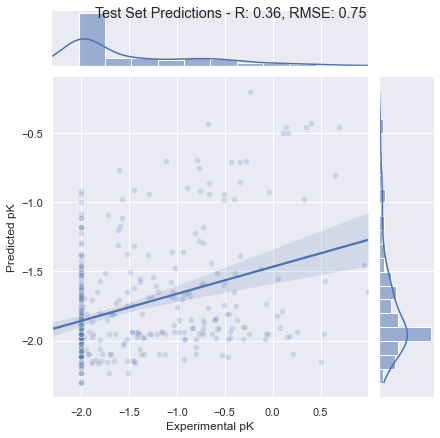

In [ ]:
test_model(X_test, y_test, automl)


# Training on features
Initially using unscaled features.

In [11]:
# combine features df with the train_split df
featurised = pd.read_pickle("pandas_dumps/featurised_compounds.pkl")
featurised = featurised.merge(right=train_split,how="left")
# extract features columns
feature_columns = featurised.columns[9:-4]
# train data
X_train = featurised[  ~featurised['test']][feature_columns]
X_train = X_train.to_numpy()
y_train = featurised[  ~featurised['test']]['pIC50']
y_train = y_train.to_numpy()
# test data 
X_test = featurised[  featurised['test']][feature_columns]
X_test = X_test.to_numpy()
y_test = featurised[  featurised['test']]['pIC50']
y_test = y_test.to_numpy()

In [16]:
from sklearn import set_config
from flaml import AutoML

set_config(display='diagram')

# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 300,  # in seconds
    "metric": 'r2',
    "task": 'regression',
    "log_file_name": "featurised.log",
}
# Train with labeled input data
automl.fit(X_train=X_train, y_train=y_train,
           **automl_settings)

print(automl.model.estimator)

[flaml.automl: 01-28 10:53:22] {2007} INFO - task = regression
[flaml.automl: 01-28 10:53:22] {2009} INFO - Data split method: uniform
[flaml.automl: 01-28 10:53:22] {2013} INFO - Evaluation method: cv
[flaml.automl: 01-28 10:53:22] {2113} INFO - Minimizing error metric: 1-r2
[flaml.automl: 01-28 10:53:22] {2170} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 01-28 10:53:22] {2437} INFO - iteration 0, current learner lgbm
[flaml.automl: 01-28 10:53:22] {2551} INFO - Estimated sufficient time budget=4231s. Estimated necessary time budget=30s.
[flaml.automl: 01-28 10:53:22] {2603} INFO -  at 0.5s,	estimator lgbm's best error=0.7511,	best estimator lgbm's best error=0.7511
[flaml.automl: 01-28 10:53:22] {2437} INFO - iteration 1, current learner lgbm
[flaml.automl: 01-28 10:53:22] {2603} INFO -  at 0.7s,	estimator lgbm's best error=0.7511,	best estimator lgbm's best error=0.7511
[flaml.automl: 01-28 10:53:22] {2437} INFO 

ExtraTreesRegressor(max_features=0.5423047717160484, max_leaf_nodes=69,
                    n_estimators=80, n_jobs=-1)


Best ML leaner: extra_tree
Best hyperparmeter config: {'n_estimators': 80, 'max_features': 0.5423047717160484, 'max_leaves': 69}
Best accuracy on validation data: 0.6049
Training duration of best run: 0.5601 s


<Figure size 432x288 with 0 Axes>

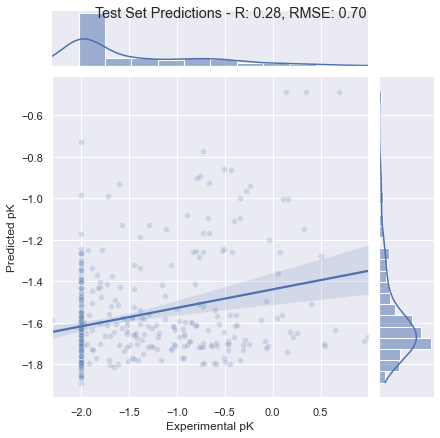

In [17]:
test_model(X_test, y_test, automl)


# Featurised with standardisation of data
Features scaled to give a mean of 0 and variance of 1. 

In [ ]:
from sklearn import preprocessing
set_config(display='diagram')

automl = AutoML()

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Specify automl goal and constraint
automl_settings = {
    "time_budget": 300,  # in seconds
    "metric": 'r2',
    "task": 'regression',
    "log_file_name": "featurised.log",
}
automl.fit(X_scaled, y_train,
                    **automl_settings)

print(automl.model.estimator)


[flaml.automl: 01-28 11:16:02] {2007} INFO - task = regression
[flaml.automl: 01-28 11:16:02] {2009} INFO - Data split method: uniform
[flaml.automl: 01-28 11:16:02] {2013} INFO - Evaluation method: cv
[flaml.automl: 01-28 11:16:02] {2113} INFO - Minimizing error metric: 1-r2
[flaml.automl: 01-28 11:16:02] {2170} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 01-28 11:16:02] {2437} INFO - iteration 0, current learner lgbm
[flaml.automl: 01-28 11:16:03] {2551} INFO - Estimated sufficient time budget=5675s. Estimated necessary time budget=40s.
[flaml.automl: 01-28 11:16:03] {2603} INFO -  at 0.6s,	estimator lgbm's best error=0.7508,	best estimator lgbm's best error=0.7508
[flaml.automl: 01-28 11:16:03] {2437} INFO - iteration 1, current learner lgbm
[flaml.automl: 01-28 11:16:03] {2603} INFO -  at 0.8s,	estimator lgbm's best error=0.7508,	best estimator lgbm's best error=0.7508
[flaml.automl: 01-28 11:16:03] {2437} INFO 

LGBMRegressor(colsample_bytree=0.5527841115816511,
              learning_rate=0.02313058432888383, max_bin=127,
              min_child_samples=9, n_estimators=280, num_leaves=8,
              reg_alpha=0.01561803679483487, reg_lambda=0.06263024946979927,
              verbose=-1)


Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 280, 'num_leaves': 8, 'min_child_samples': 9, 'learning_rate': 0.02313058432888383, 'log_max_bin': 7, 'colsample_bytree': 0.5527841115816511, 'reg_alpha': 0.01561803679483487, 'reg_lambda': 0.06263024946979927}
Best accuracy on validation data: 0.608
Training duration of best run: 0.5749 s


<Figure size 432x288 with 0 Axes>

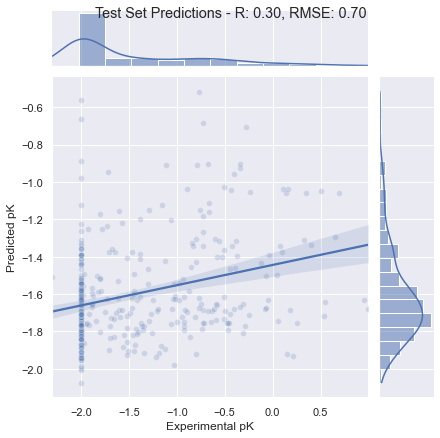

In [ ]:
test_model(X_test_scaled,y_test,automl)